# Movie Genre Classification

This notebook builds a machine learning model to predict movie genres based on plot summaries.

**Techniques Used:**
- TF-IDF Vectorization
- Naive Bayes Classifier
- Logistic Regression
- Support Vector Machine (SVM)

## 1. Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Data

In [5]:
# Load training data
train_data = []
with open('Genre Classification Dataset/train_data.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split(' ::: ')
        if len(parts) == 4:
            train_data.append({
                'ID': parts[0],
                'Title': parts[1],
                'Genre': parts[2],
                'Description': parts[3]
            })

train_df = pd.DataFrame(train_data)

# Load test data
test_data = []
with open('Genre Classification Dataset/test_data.txt', 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split(' ::: ')
        if len(parts) == 3:
            test_data.append({
                'ID': parts[0],
                'Title': parts[1],
                'Description': parts[2]
            })

test_df = pd.DataFrame(test_data)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nFirst few rows of training data:")
train_df.head()

Training data shape: (54214, 4)
Test data shape: (54200, 3)

First few rows of training data:


,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


## 3. Exploratory Data Analysis

In [6]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
print("\nData types:")
print(train_df.dtypes)

Missing values in training data:
ID             0
Title          0
Genre          0
Description    0
dtype: int64

Data types:
ID             object
Title          object
Genre          object
Description    object
dtype: object


Number of unique genres: 27

Top 20 most common genres:
Genre
drama          13613
documentary    13096
comedy          7447
short           5073
horror          2204
thriller        1591
action          1315
western         1032
reality-tv       884
family           784
adventure        775
music            731
romance          672
sci-fi           647
adult            590
crime            505
animation        498
sport            432
talk-show        391
fantasy          323
Name: count, dtype: int64


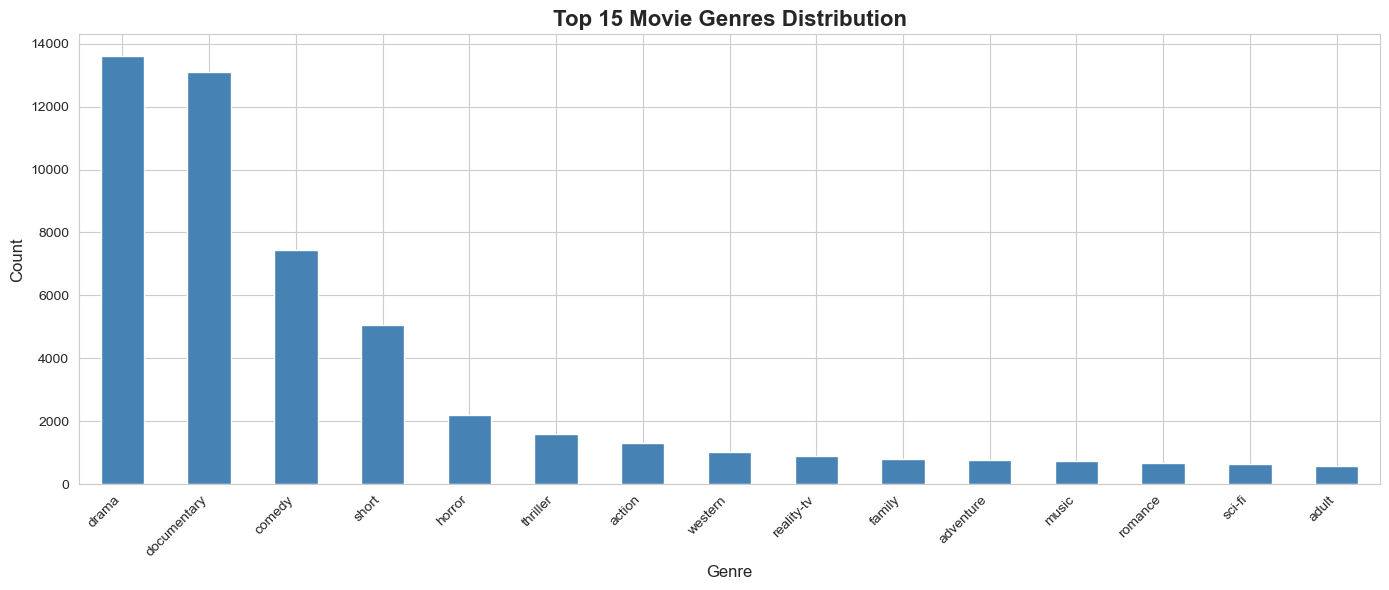

In [7]:
# Genre distribution
print(f"Number of unique genres: {train_df['Genre'].nunique()}")
print("\nTop 20 most common genres:")
genre_counts = train_df['Genre'].value_counts()
print(genre_counts.head(20))

# Visualize top 15 genres
plt.figure(figsize=(14, 6))
genre_counts.head(15).plot(kind='bar', color='steelblue')
plt.title('Top 15 Movie Genres Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Description length statistics:
count    54214.000000
mean       101.907386
std         76.579192
min          6.000000
25%         55.000000
50%         79.000000
75%        121.000000
max       1829.000000
Name: description_length, dtype: float64


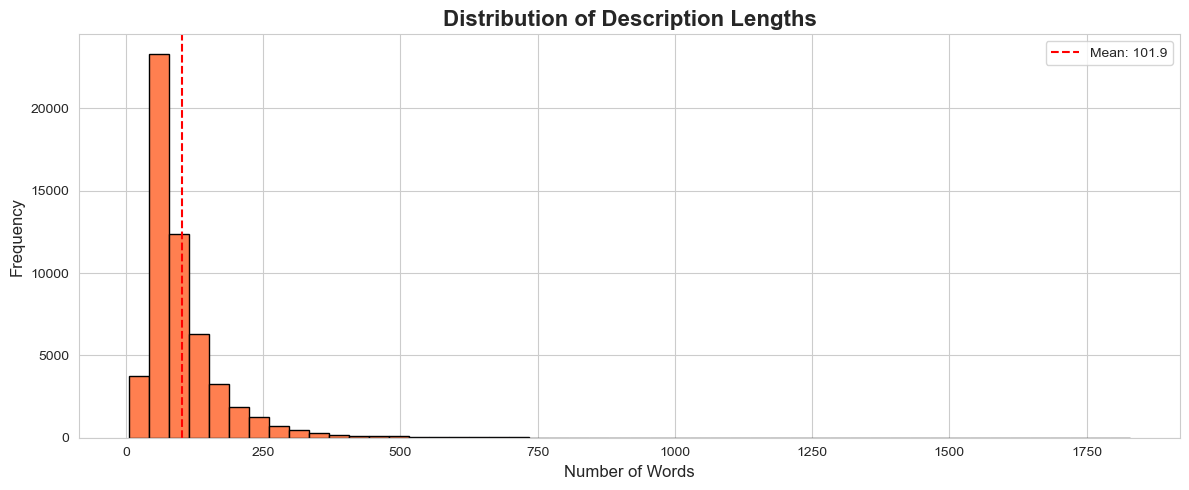

In [8]:
# Text length analysis
train_df['description_length'] = train_df['Description'].apply(lambda x: len(str(x).split()))

print("Description length statistics:")
print(train_df['description_length'].describe())

plt.figure(figsize=(12, 5))
plt.hist(train_df['description_length'], bins=50, color='coral', edgecolor='black')
plt.title('Distribution of Description Lengths', fontsize=16, fontweight='bold')
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(train_df['description_length'].mean(), color='red', linestyle='--', label=f'Mean: {train_df["description_length"].mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Text Preprocessing

In [9]:
def clean_text(text):
    """Clean and preprocess text data"""
    # Convert to string and lowercase
    text = str(text).lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply cleaning
print("Cleaning text data...")
train_df['clean_description'] = train_df['Description'].apply(clean_text)
test_df['clean_description'] = test_df['Description'].apply(clean_text)

print("\nExample of cleaned text:")
print("Original:", train_df['Description'].iloc[0][:200])
print("\nCleaned:", train_df['clean_description'].iloc[0][:200])

Cleaning text data...

Example of cleaned text:
Original: Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone

Cleaned: listening in to a conversation between his doctor and parents yearold oscar learns what nobody has the courage to tell him he only has a few weeks to live furious he refuses to speak to anyone except 


## 5. Feature Engineering - TF-IDF Vectorization

In [10]:
# Split training data for validation
X = train_df['clean_description']
y = train_df['Genre']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 43371
Validation set size: 10843


In [11]:
# Create TF-IDF vectorizer
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.8)

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print(f"\nTF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf.get_feature_names_out())}")

Creating TF-IDF features...

TF-IDF matrix shape: (43371, 5000)
Number of features: 5000


## 6. Model Training and Evaluation

### 6.1 Naive Bayes Classifier

In [12]:
print("Training Naive Bayes Classifier...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predictions
nb_train_pred = nb_model.predict(X_train_tfidf)
nb_val_pred = nb_model.predict(X_val_tfidf)

# Evaluation
nb_train_acc = accuracy_score(y_train, nb_train_pred)
nb_val_acc = accuracy_score(y_val, nb_val_pred)

print(f"\nNaive Bayes Results:")
print(f"Training Accuracy: {nb_train_acc:.4f}")
print(f"Validation Accuracy: {nb_val_acc:.4f}")

Training Naive Bayes Classifier...

Naive Bayes Results:
Training Accuracy: 0.5289
Validation Accuracy: 0.5050


### 6.2 Logistic Regression

In [13]:
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_tfidf)
lr_val_pred = lr_model.predict(X_val_tfidf)

# Evaluation
lr_train_acc = accuracy_score(y_train, lr_train_pred)
lr_val_acc = accuracy_score(y_val, lr_val_pred)

print(f"\nLogistic Regression Results:")
print(f"Training Accuracy: {lr_train_acc:.4f}")
print(f"Validation Accuracy: {lr_val_acc:.4f}")

Training Logistic Regression...

Logistic Regression Results:
Training Accuracy: 0.6592
Validation Accuracy: 0.5726


### 6.3 Support Vector Machine (SVM)

In [14]:
print("Training Support Vector Machine...")
svm_model = LinearSVC(random_state=42, max_iter=1000, C=1.0)
svm_model.fit(X_train_tfidf, y_train)

# Predictions
svm_train_pred = svm_model.predict(X_train_tfidf)
svm_val_pred = svm_model.predict(X_val_tfidf)

# Evaluation
svm_train_acc = accuracy_score(y_train, svm_train_pred)
svm_val_acc = accuracy_score(y_val, svm_val_pred)

print(f"\nSVM Results:")
print(f"Training Accuracy: {svm_train_acc:.4f}")
print(f"Validation Accuracy: {svm_val_acc:.4f}")

Training Support Vector Machine...

SVM Results:
Training Accuracy: 0.7855
Validation Accuracy: 0.5619


## 7. Model Comparison


MODEL COMPARISON
              Model  Training Accuracy  Validation Accuracy
        Naive Bayes           0.528856             0.505026
Logistic Regression           0.659196             0.572628
                SVM           0.785548             0.561929


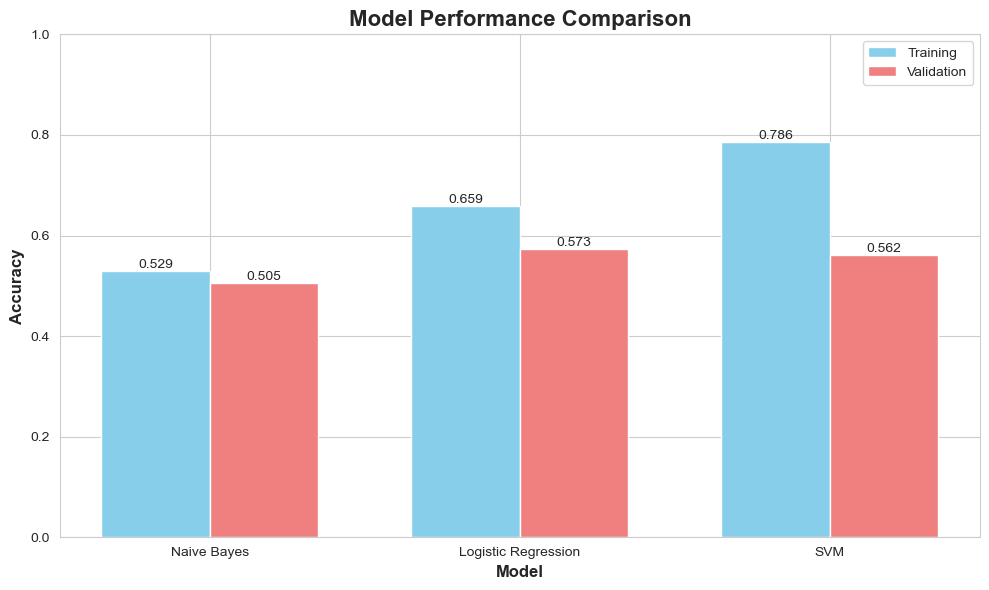


🏆 Best Model: Logistic Regression with Validation Accuracy: 0.5726


In [15]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Naive Bayes', 'Logistic Regression', 'SVM'],
    'Training Accuracy': [nb_train_acc, lr_train_acc, svm_train_acc],
    'Validation Accuracy': [nb_val_acc, lr_val_acc, svm_val_acc]
})

print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results.to_string(index=False))
print("="*60)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results['Model']))
width = 0.35

bars1 = ax.bar(x - width/2, results['Training Accuracy'], width, label='Training', color='skyblue')
bars2 = ax.bar(x + width/2, results['Validation Accuracy'], width, label='Validation', color='lightcoral')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Determine best model
best_model_idx = results['Validation Accuracy'].idxmax()
best_model_name = results.loc[best_model_idx, 'Model']
best_model_acc = results.loc[best_model_idx, 'Validation Accuracy']

print(f"\n🏆 Best Model: {best_model_name} with Validation Accuracy: {best_model_acc:.4f}")

## 8. Detailed Evaluation of Best Model

In [16]:
# Select best model based on validation accuracy
if best_model_name == 'Naive Bayes':
    best_model = nb_model
    best_pred = nb_val_pred
elif best_model_name == 'Logistic Regression':
    best_model = lr_model
    best_pred = lr_val_pred
else:
    best_model = svm_model
    best_pred = svm_val_pred

# Classification report
print(f"\nDetailed Classification Report for {best_model_name}:")
print("="*80)
print(classification_report(y_val, best_pred))


Detailed Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      action       0.47      0.23      0.31       263
       adult       0.76      0.30      0.43       118
   adventure       0.59      0.08      0.15       155
   animation       0.46      0.06      0.11       100
   biography       0.00      0.00      0.00        53
      comedy       0.50      0.57      0.53      1490
       crime       0.25      0.02      0.04       101
 documentary       0.67      0.87      0.76      2619
       drama       0.53      0.76      0.63      2723
      family       0.56      0.09      0.15       157
     fantasy       0.00      0.00      0.00        65
   game-show       1.00      0.41      0.58        39
     history       0.00      0.00      0.00        49
      horror       0.63      0.54      0.58       441
       music       0.66      0.42      0.51       146
     musical       0.00      0.00      0.00        55
     mystery       0.00 

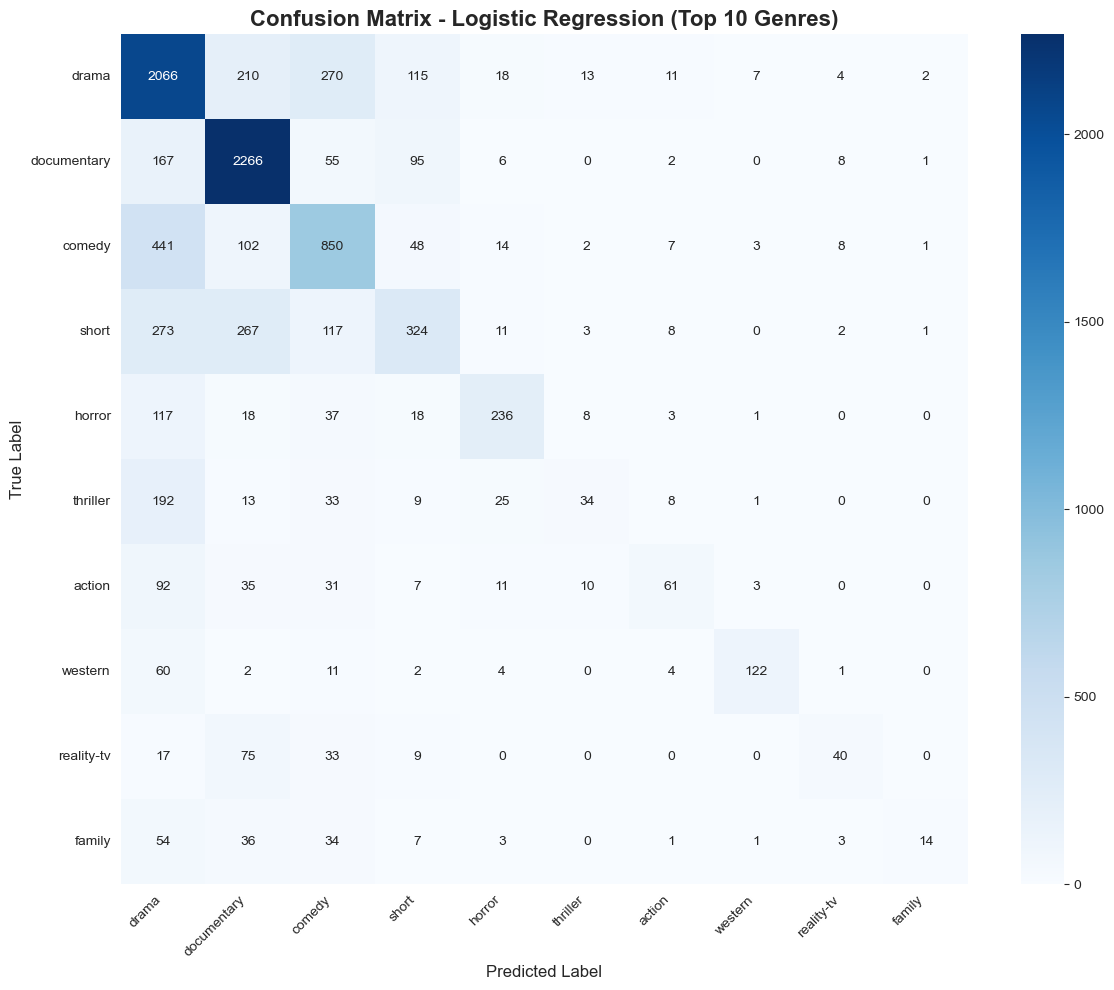

In [19]:
# Confusion Matrix for top genres
top_genres = train_df['Genre'].value_counts().head(10).index.tolist()
mask = y_val.isin(top_genres)
y_val_top = y_val[mask]

# Fix: Reset the index when creating the Series from best_pred
best_pred_series = pd.Series(best_pred, index=y_val.index)
best_pred_top = best_pred_series[mask]

cm = confusion_matrix(y_val_top, best_pred_top, labels=top_genres)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=top_genres, yticklabels=top_genres)
plt.title(f'Confusion Matrix - {best_model_name} (Top 10 Genres)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 9. Train Final Model on Full Training Data

In [21]:
print(f"Training final {best_model_name} model on full training data...")

# Retrain TF-IDF on full training data
X_full = train_df['clean_description']
y_full = train_df['Genre']

tfidf_final = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.8)
X_full_tfidf = tfidf_final.fit_transform(X_full)

# Train final model
if best_model_name == 'Naive Bayes':
    final_model = MultinomialNB()
elif best_model_name == 'Logistic Regression':
    final_model = LogisticRegression(max_iter=1000, random_state=42, C=1.0)
else:
    final_model = LinearSVC(random_state=42, max_iter=1000, C=1.0)

final_model.fit(X_full_tfidf, y_full)
print("✓ Final model trained successfully!")

Training final Logistic Regression model on full training data...
✓ Final model trained successfully!


## 10. Make Predictions on Test Data

In [22]:
print("Making predictions on test data...")

# Transform test data
X_test = test_df['clean_description']
X_test_tfidf = tfidf_final.transform(X_test)

# Predict
test_predictions = final_model.predict(X_test_tfidf)

# Add predictions to test dataframe
test_df['Predicted_Genre'] = test_predictions

print(f"\n✓ Predictions completed for {len(test_predictions)} movies!")
print("\nSample predictions:")
print(test_df[['ID', 'Title', 'Predicted_Genre']].head(10))

Making predictions on test data...

✓ Predictions completed for 54200 movies!

Sample predictions:
   ID                                       Title Predicted_Genre
0   1                        Edgar's Lunch (1998)          comedy
1   2                    La guerra de papá (1977)           drama
2   3                 Off the Beaten Track (2010)     documentary
3   4                      Meu Amigo Hindu (2015)           drama
4   5                           Er nu zhai (1955)           drama
5   6                          Riddle Room (2016)           short
6   7                              L'amica (1969)           drama
7   8                        Ina Mina Dika (1989)          comedy
8   9  Equinox Special: Britain's Tornados (2005)     documentary
9  10                                Press (2011)           drama


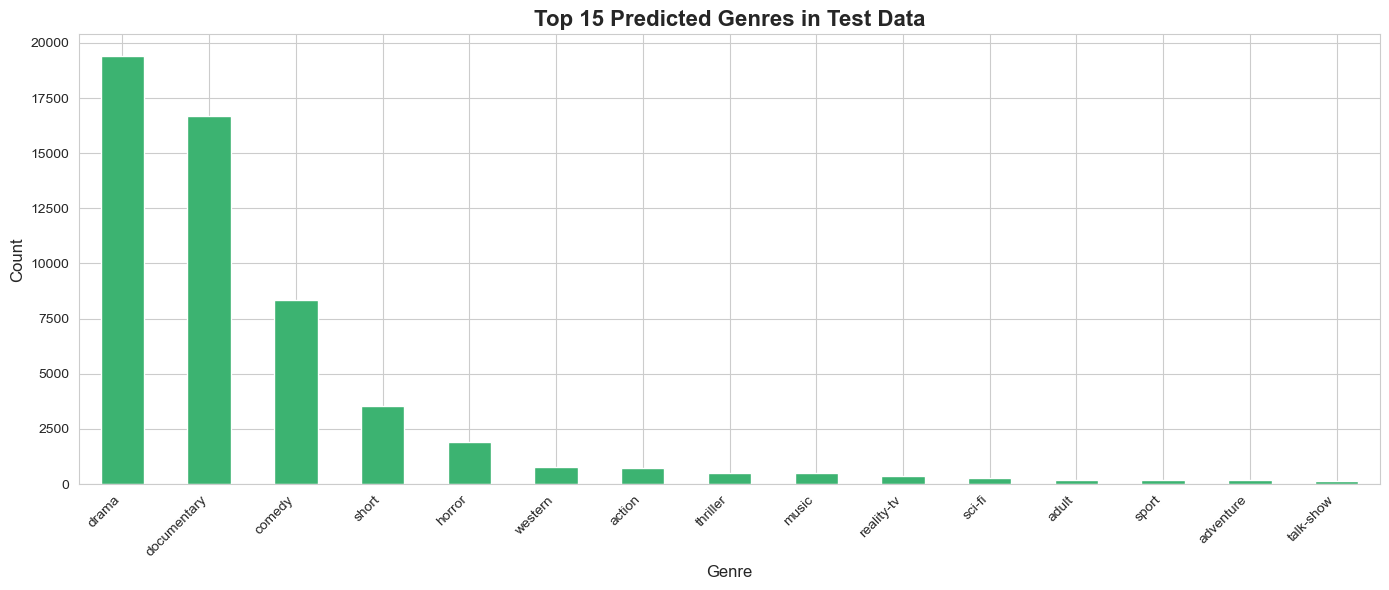

In [23]:
# Visualize predicted genre distribution
plt.figure(figsize=(14, 6))
test_df['Predicted_Genre'].value_counts().head(15).plot(kind='bar', color='mediumseagreen')
plt.title('Top 15 Predicted Genres in Test Data', fontsize=16, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 11. Save Predictions

In [24]:
# Save predictions to file
output_file = 'predictions.txt'

with open(output_file, 'w', encoding='utf-8') as f:
    for idx, row in test_df.iterrows():
        f.write(f"{row['ID']} ::: {row['Predicted_Genre']}\n")

print(f"✓ Predictions saved to '{output_file}'")
print(f"\nTotal predictions: {len(test_df)}")

✓ Predictions saved to 'predictions.txt'

Total predictions: 54200


## 12. Summary

In [25]:
print("\n" + "="*80)
print("MOVIE GENRE CLASSIFICATION - SUMMARY")
print("="*80)
print(f"\n📊 Dataset Statistics:")
print(f"   • Training samples: {len(train_df)}")
print(f"   • Test samples: {len(test_df)}")
print(f"   • Number of unique genres: {train_df['Genre'].nunique()}")
print(f"\n🔧 Feature Engineering:")
print(f"   • Method: TF-IDF Vectorization")
print(f"   • Features: {X_full_tfidf.shape[1]}")
print(f"   • N-grams: (1, 2)")
print(f"\n🤖 Models Evaluated:")
for idx, row in results.iterrows():
    print(f"   • {row['Model']}: {row['Validation Accuracy']:.4f}")
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   • Validation Accuracy: {best_model_acc:.4f}")
print(f"\n💾 Output:")
print(f"   • Predictions saved to: {output_file}")
print("\n" + "="*80)
print("✓ Analysis Complete!")
print("="*80)


MOVIE GENRE CLASSIFICATION - SUMMARY

📊 Dataset Statistics:
   • Training samples: 54214
   • Test samples: 54200
   • Number of unique genres: 27

🔧 Feature Engineering:
   • Method: TF-IDF Vectorization
   • Features: 5000
   • N-grams: (1, 2)

🤖 Models Evaluated:
   • Naive Bayes: 0.5050
   • Logistic Regression: 0.5726
   • SVM: 0.5619

🏆 Best Model: Logistic Regression
   • Validation Accuracy: 0.5726

💾 Output:
   • Predictions saved to: predictions.txt

✓ Analysis Complete!


In [27]:

def predict_movie_genre(description):
    """
    Predict the genre of a movie based on its description
    
    Parameters:
    description (str): The plot description of your movie
    
    Returns:
    str: Predicted genre
    """
    # Clean the description
    cleaned_desc = clean_text(description)
    
    # Transform using TF-IDF
    desc_tfidf = tfidf_final.transform([cleaned_desc])
    
    # Predict genre
    predicted_genre = final_model.predict(desc_tfidf)[0]
    
    return predicted_genre

# Example usage:
my_movie_description = """
A young wizard discovers he has magical powers and is invited to attend 
a school of witchcraft and wizardry. There, he makes friends and faces 
a dark evil force that threatens the magical world.
"""

predicted_genre = predict_movie_genre(my_movie_description)
print(f"🎬 Predicted Genre: {predicted_genre.upper()}")

🎬 Predicted Genre: ANIMATION


In [29]:
# Interactive movie genre prediction
print("=" * 60)
print("MOVIE GENRE PREDICTOR")
print("=" * 60)

movie_description = input("\nEnter your movie plot description:\n")

if movie_description.strip():
    predicted_genre = predict_movie_genre(movie_description)
    print(f"\n🎬 Predicted Genre: {predicted_genre.upper()}")
    print("=" * 60)
else:
    print("No description provided!")

MOVIE GENRE PREDICTOR

🎬 Predicted Genre: ACTION
